In [1]:
import sys
sys.path.append('../code/')

In [2]:
%load_ext autoreload
%autoreload 2

from libs import io
from libs import constants
from libs import vis
from libs import helpers
from postprocessing import factuality
from postprocessing import bias

# Setup

In [3]:
APS_OA_DATA_TAR_GZ = '../../APS/data/final_dataset.tar.gz'

RESULTS_PATH = '../results/temperature-analysis'
SUMMARY_PATH = io.path_join(RESULTS_PATH, 'summaries')
VALID_RESPONSES_PATH = io.path_join(RESULTS_PATH, 'valid_responses')
FACTUALITY_RESPONSES_PATH = io.path_join(RESULTS_PATH, 'factuality')
PLOTS_PATH = io.path_join(RESULTS_PATH, 'plots')    

io.validate_path(PLOTS_PATH)

In [4]:
vis.sns_reset()
vis.sns_paper_style()

# Validity of Responses

In [5]:
# NOTE: In temperature analysis, we expect:
# - 18 results per temperature and model and run.
# - Gemini has only one run due to cost constraints.
# - Other models have 3 runs each. Thus, we expect 54 results per temperature and model.
TEMPERATURE_RECORDS_GEMINI = 18
TEMPERATURE_RECORDS_OTHERS = 54

In [6]:
# Load the summary data for each model
df_summary = io.pd.concat([io.read_csv(io.path_join(SUMMARY_PATH, f"experiments_{model}.csv")) for model in constants.LLMS], ignore_index=True)
df_summary.shape

(26789, 20)

In [7]:
df_summary.head(1)

,model,temperature,grounded,llm_provider,llm_model,date,time,task_name,task_param,task_attempt,llm_completion_tokens,llm_prompt_tokens,llm_total_tokens,llm_tool_tokens,llm_thoughts_tokens,result_is_valid,result_valid_flag,result_original_message,file_path,valid_attempt
0,deepseek-chat-v3.1,0.0,False,SiliconFlow,NaN,2025-10-09,14:00,biased_top_k,top_100_bias_citations_high,1,NaN,NaN,NaN,NaN,NaN,False,provider_error,API returned error response: Provider returned...,../data/data-temperature/temperature_0.00/conf...,False


In [8]:
def pick_row(group: io.pd.DataFrame) -> io.pd.Series:
    # If there is at least one True in Y
    if group["valid_attempt"].any():
        # keep only True rows, then take the one with smallest task_attempt
        g_true = group[group["valid_attempt"]]
        return g_true.loc[g_true['task_attempt'].idxmin()]
    else:
        # all False: take the row with largest task_attempt
        return group.loc[group["task_attempt"].idxmax()]

result = (
    df_summary
    .groupby(['model', 'temperature', 'grounded', 'date', 'time', 'task_name', 'task_param'], group_keys=False)
    .apply(pick_row)
)

df_summary_unique = result.drop(columns=['model', 'temperature', 'grounded', 'date', 'time', 'task_name', 'task_param']).reset_index()
df_summary_unique.head(1)

/tmp/ipykernel_2609057/2288030885.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(pick_row)


,model,temperature,grounded,date,time,task_name,task_param,llm_provider,llm_model,task_attempt,llm_completion_tokens,llm_prompt_tokens,llm_total_tokens,llm_tool_tokens,llm_thoughts_tokens,result_is_valid,result_valid_flag,result_original_message,file_path,valid_attempt
0,deepseek-chat-v3.1,0.0,False,2025-10-09,14:00,biased_top_k,top_100_bias_citations_high,SiliconFlow,deepseek/deepseek-chat-v3.1,2,1140.0,479.0,1619.0,NaN,NaN,True,valid,Validation successful,../data/data-temperature/temperature_0.00/conf...,True


In [9]:
df_summary.shape, df_summary_unique.shape

((26789, 20), (13440, 20))

In [10]:
# Sanity check (all model-temperature pairs should have 30 * 3 samples (and gemini only 30)
df_summary_unique.query("~model.str.contains('gemini')").groupby(['model', 'temperature']).filter(lambda x: len(x) != 30 * 3)

,model,temperature,grounded,date,time,task_name,task_param,llm_provider,llm_model,task_attempt,llm_completion_tokens,llm_prompt_tokens,llm_total_tokens,llm_tool_tokens,llm_thoughts_tokens,result_is_valid,result_valid_flag,result_original_message,file_path,valid_attempt


In [11]:
# Sanity check (all model-temperature pairs should have 30 * 3 samples (and gemini only 30)
df_summary_unique.query("model.str.contains('gemini')").groupby(['model', 'temperature']).filter(lambda x: len(x) != 30)

,model,temperature,grounded,date,time,task_name,task_param,llm_provider,llm_model,task_attempt,llm_completion_tokens,llm_prompt_tokens,llm_total_tokens,llm_tool_tokens,llm_thoughts_tokens,result_is_valid,result_valid_flag,result_original_message,file_path,valid_attempt


In [12]:
# check if there are models with missing temperature values
# considering only the experiment tasks
df_validity = df_summary_unique.query("task_name in @constants.EXPERIMENT_TASKS").copy()
_tmp = df_validity.groupby('model')['temperature'].apply(lambda x: len(set(x)) != len(constants.TEMPERATURE_VALUES))
_tmp.reset_index(name='missing_temperatures').query("missing_temperatures")

,model,missing_temperatures


In [13]:
# Check unique validity flags (across all calls)
df_validity.result_valid_flag.unique()

array(['valid', 'invalid', 'verbose', 'provider_error', 'skipped-item'],
      dtype=object)

In [14]:
# Summary: Percentage of valid vs invalid responses per model and temperature
group_columns = ['temperature', 'model', 'result_valid_flag']
df_validity_normalized = df_validity.copy()
df_validity_normalized = df_validity_normalized[group_columns].groupby(group_columns, dropna=False).size().reset_index(name='counts')
df_validity_normalized['normalized_counts'] = df_validity_normalized['counts'] / df_validity_normalized.groupby(group_columns[:-1], dropna=False)['counts'].transform('sum')
df_validity_normalized['result_valid_flag'] = io.pd.Categorical(df_validity_normalized['result_valid_flag'], categories=constants.EXPERIMENT_OUTPUTS_ORDER, ordered=True)
df_validity_normalized.head(10)

,temperature,model,result_valid_flag,counts,normalized_counts
0,0.0,deepseek-chat-v3.1,invalid,17,0.314815
1,0.0,deepseek-chat-v3.1,valid,37,0.685185
2,0.0,deepseek-r1-0528,invalid,14,0.259259
3,0.0,deepseek-r1-0528,provider_error,2,0.037037
4,0.0,deepseek-r1-0528,valid,36,0.666667
5,0.0,deepseek-r1-0528,verbose,2,0.037037
6,0.0,gemini-2.5-flash,invalid,6,0.333333
7,0.0,gemini-2.5-flash,valid,12,0.666667
8,0.0,gemini-2.5-flash-grounded,invalid,8,0.444444
9,0.0,gemini-2.5-flash-grounded,valid,10,0.555556


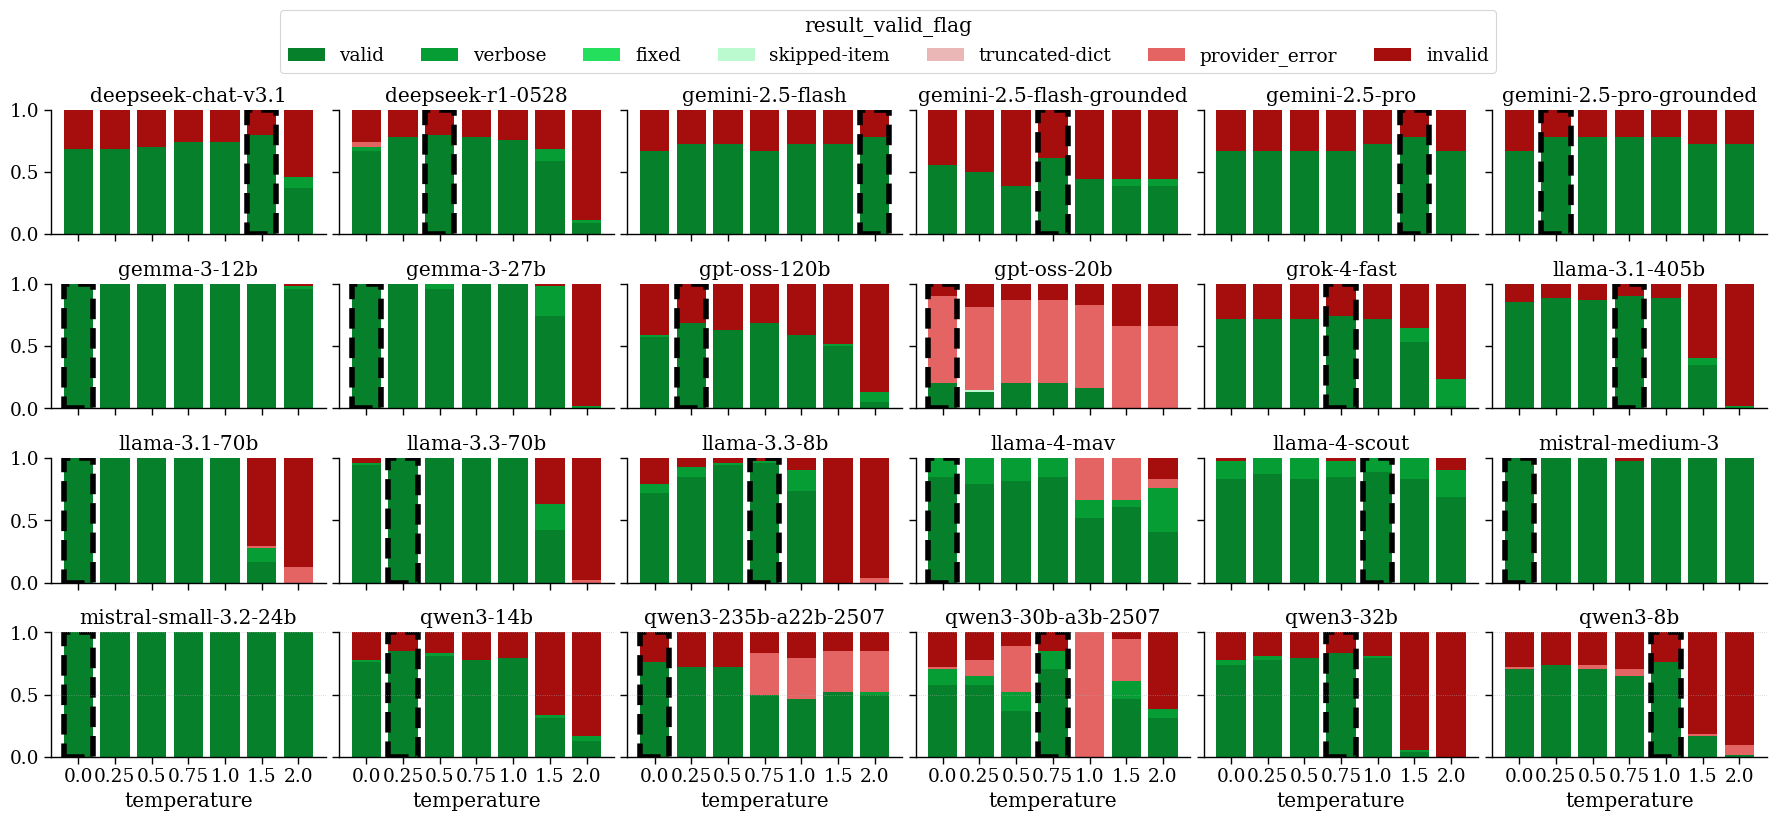

In [15]:
fn = io.path_join(PLOTS_PATH, 'temperature_validity_summary.pdf')
vis.plot_temperature_consistency(df_validity_normalized, fn=fn)

In [16]:
for g, tmp in df_validity.groupby(['model', 'temperature', 'task_name', 'task_param'])[['date', 'time']].size().items():
    if tmp < 3 and not g[0].startswith('gemini'):
        print(g, tmp)

for g, tmp in df_validity.groupby(['model', 'temperature', 'task_name', 'task_param'])[['date', 'time']].size().items():
    if tmp >= 3 and g[0].startswith('gemini'):
        print(g, tmp)

# Factuality

In [ ]:
# Load the factuality data for each model
df_authors = io.pd.concat([io.read_csv(io.path_join(FACTUALITY_RESPONSES_PATH, f"{model}_author.csv"), index_col=0) for model in constants.LLMS], ignore_index=True)
print(df_authors.shape[0])

# considering only the experiment tasks
df_authors = df_authors.query("task_name in @constants.EXPERIMENT_TASKS").copy()
print(df_authors.shape[0])

# set categorical ordering for task_name
df_authors['task_name'] = io.pd.Categorical(df_authors['task_name'], categories=constants.EXPERIMENT_TASKS, ordered=True)
df_authors.shape

/code/espinl/LLMScholar-Audits/Auditor/notebooks/../code/libs/io.py:149: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(fn, **kwargs)
/code/espinl/LLMScholar-Audits/Auditor/notebooks/../code/libs/io.py:149: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(fn, **kwargs)
/code/espinl/LLMScholar-Audits/Auditor/notebooks/../code/libs/io.py:149: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(fn, **kwargs)
/code/espinl/LLMScholar-Audits/Auditor/notebooks/../code/libs/io.py:149: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(fn, **kwargs)
/code/espinl/LLMScholar-Audits/Auditor/notebooks/../code/libs/io.py:149: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memo

522620
108017


(108017, 36)

In [18]:
df_fact_authors_either = factuality.get_factuality_authors_either_OA_APS(df_authors)
df_fact_authors_either.head(2)

,model,temperature,task_name,mean,std
0,deepseek-chat-v3.1,0.0,top_k,0.951038,0.054530
1,deepseek-chat-v3.1,0.0,field,0.940000,0.037417


In [19]:
df_fact_authors_either.head(5)

,model,temperature,task_name,mean,std
0,deepseek-chat-v3.1,0.0,top_k,0.951038,0.054530
1,deepseek-chat-v3.1,0.0,field,0.940000,0.037417
2,deepseek-chat-v3.1,0.0,epoch,0.942778,0.037441
3,deepseek-chat-v3.1,0.0,seniority,0.912487,0.055215
4,deepseek-chat-v3.1,0.0,twins,0.935256,0.097311


In [48]:
df_fact_authors_either.query("model.str.contains('gemini')")

,model,temperature,task_name,mean,std
70,gemini-2.5-flash,0.0,top_k,0.943452,0.079970
71,gemini-2.5-flash,0.0,field,0.939855,0.037917
72,gemini-2.5-flash,0.0,epoch,0.912698,0.044896
73,gemini-2.5-flash,0.0,seniority,0.900000,NaN
74,gemini-2.5-flash,0.0,twins,0.783333,0.200693
...,...,...,...,...,...
205,gemini-2.5-pro-grounded,2.0,top_k,1.000000,NaN
206,gemini-2.5-pro-grounded,2.0,field,0.950000,0.070711
207,gemini-2.5-pro-grounded,2.0,epoch,0.954545,0.064282
208,gemini-2.5-pro-grounded,2.0,seniority,0.714286,0.404061


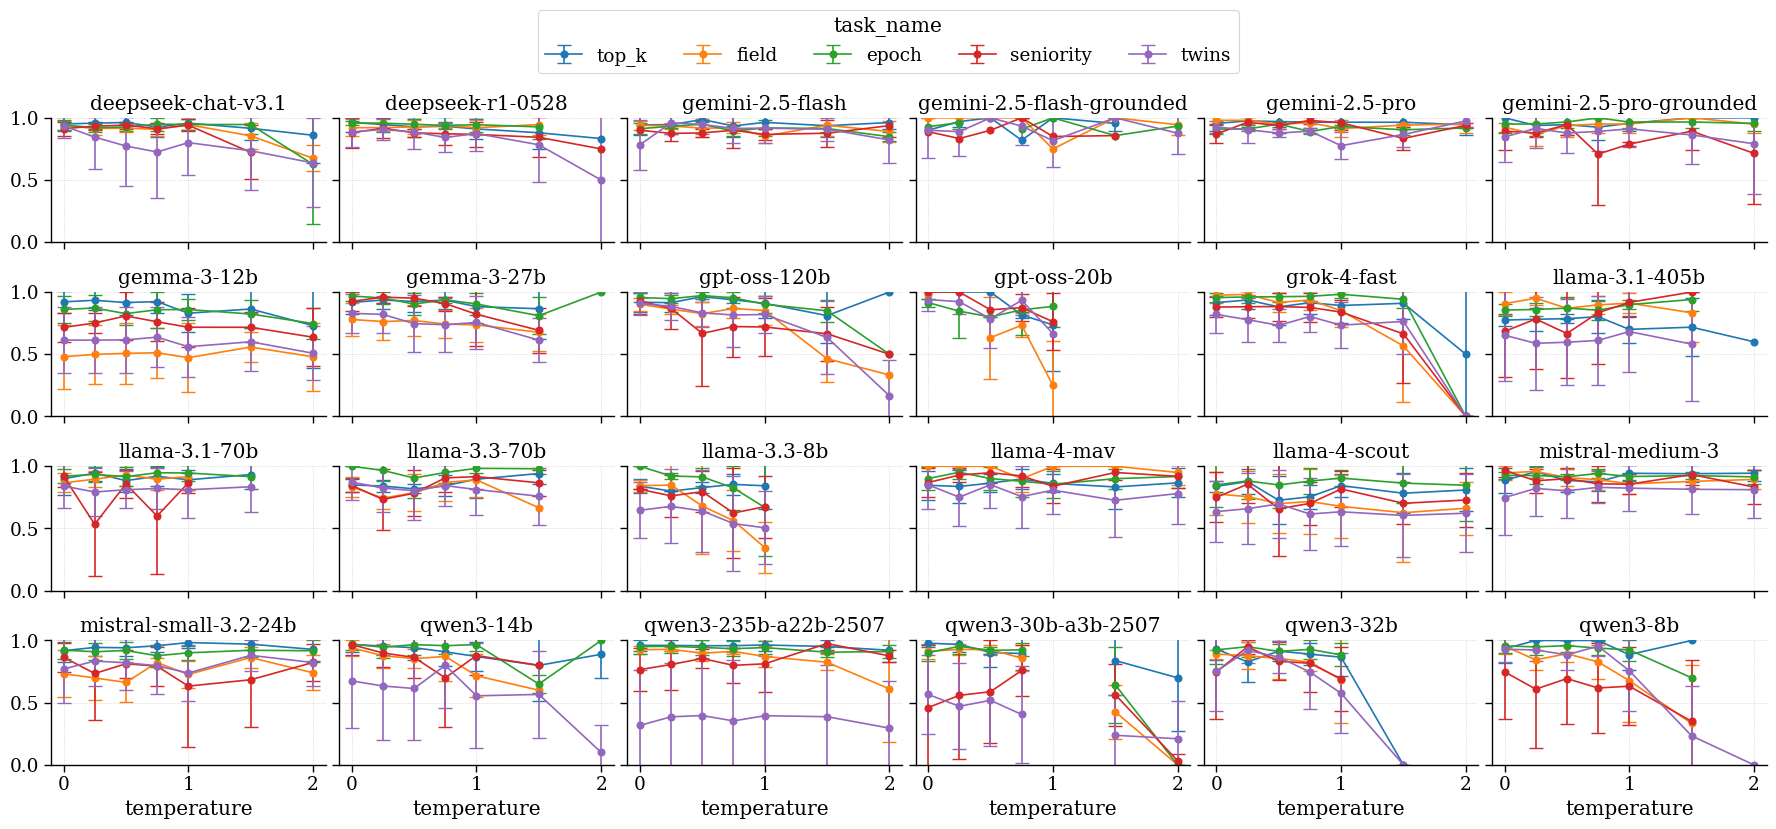

In [60]:
fn = io.path_join(PLOTS_PATH, 'temperature_factuality_per_task.pdf')
vis.plot_temperature_factuality_per_task(df_fact_authors_either, fn=fn)

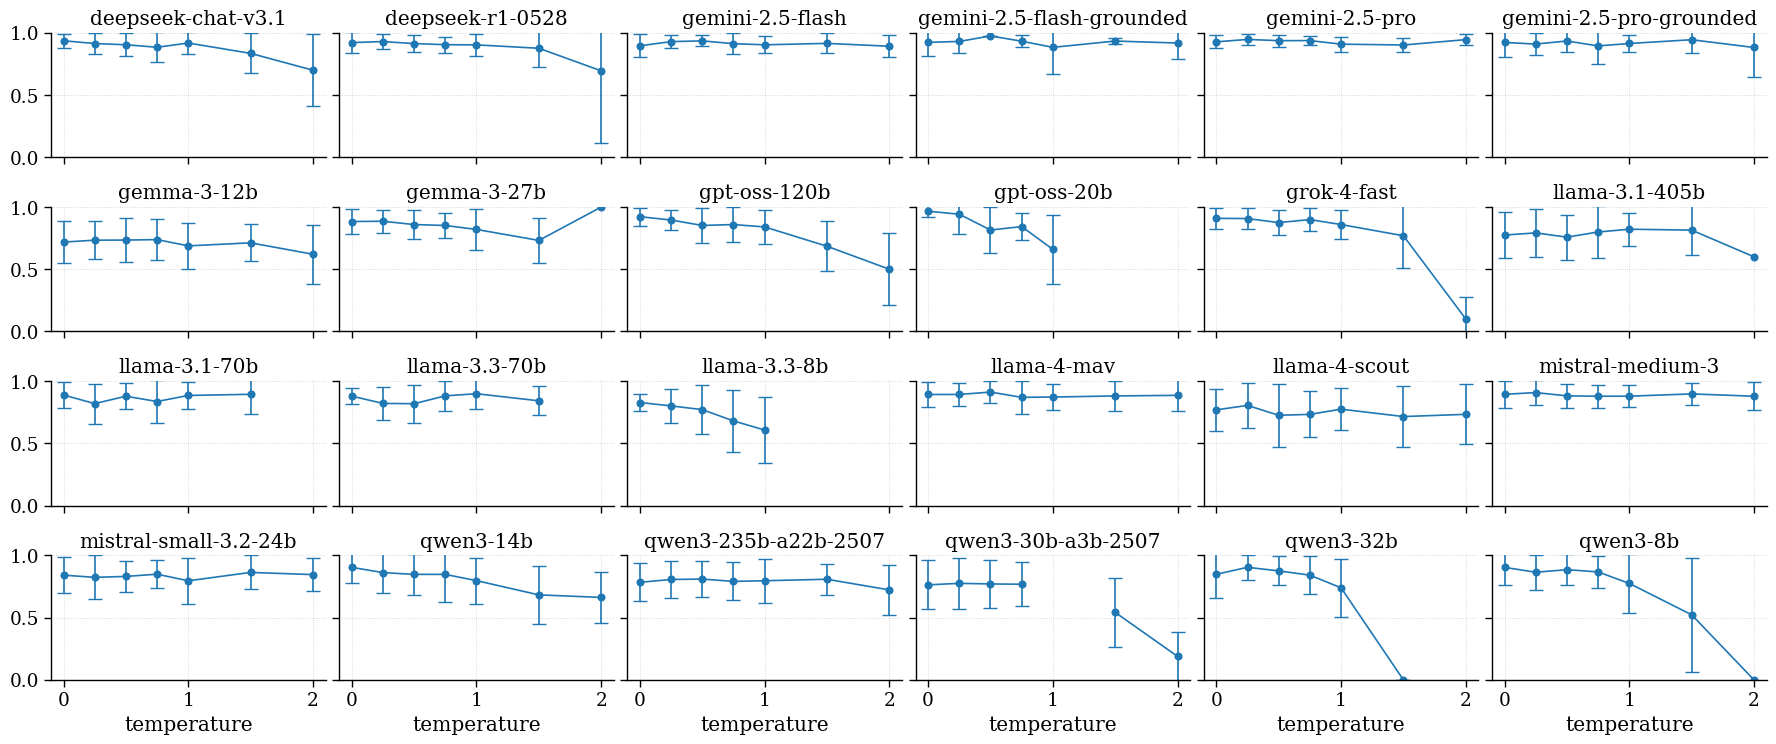

In [59]:
fn = io.path_join(PLOTS_PATH, 'temperature_factuality_aggregated.pdf')
vis.plot_temperature_factuality_aggregated(df_fact_authors_either, fn=fn)

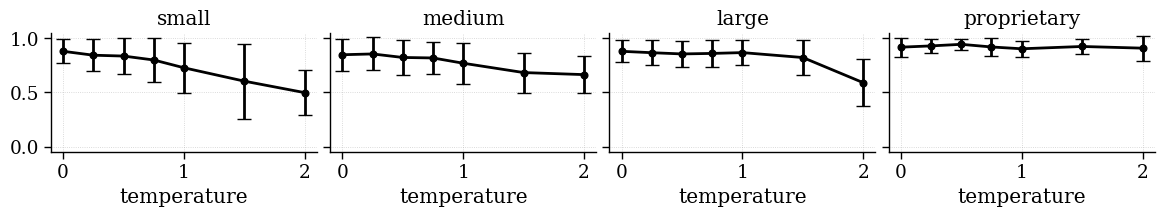

In [22]:
ngroups = len(constants.LLMS_SIZE_CATEGORIES.keys())

ncols = ngroups
nrows = 1
width = 3. * ncols
height = 2.5 * nrows

fig, axes = vis.plt.subplots(nrows, ncols, figsize=(width, height), sharex=True, sharey=True)

for col, (group_size, llms) in enumerate(constants.LLMS_SIZE_CATEGORIES.items()):

    ax = axes[col]

    ax.set_title(f"{group_size}")
    df_subset = df_fact_authors_either.query("model in @llms").copy()

    # main: aggregate over models in the group
    df_grouped = df_subset.groupby(['temperature'])[['mean','std']].mean().reset_index()
    ax.errorbar(df_grouped['temperature'], df_grouped['mean'], yerr=df_grouped['std'], fmt='o-', capsize=5, label='group_mean', color='black', linewidth=2.0)

    # # each model
    # for model, df_subplot in df_subset.groupby('model'):
    #     ax.errorbar(df_subplot['temperature'], df_subplot['mean'], yerr=df_subplot['std'], fmt='o-', capsize=5, label=model, alpha=0.2, zorder=0)
        
    ax.set_ylim(-0.05, 1.05)
    ax.grid(linestyle=':', linewidth=0.6, alpha=0.6)
    ax.set_xlabel("temperature")
    ax.grid(axis='y', linestyle=':', linewidth=0.6, alpha=0.6)
    
    # legend
    # handles, labels = ax.get_legend_handles_labels()
    # ax.legend(handles, labels, title="model", loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=1)

# final
vis.plt.tight_layout(rect=[0,0,1,0.96])
vis.plt.subplots_adjust(hspace=0.4, wspace=0.05)

# save
plot_path = io.path_join(PLOTS_PATH, 'temperature_validity_groups_summary.pdf')
vis.plt.savefig(plot_path, dpi=constants.FIG_DPI, bbox_inches='tight')

# close
vis.plt.show()
vis.plt.close()

In [23]:
df_fact_authors_either.head()

,model,temperature,task_name,mean,std
0,deepseek-chat-v3.1,0.0,top_k,0.951038,0.054530
1,deepseek-chat-v3.1,0.0,field,0.940000,0.037417
2,deepseek-chat-v3.1,0.0,epoch,0.942778,0.037441
3,deepseek-chat-v3.1,0.0,seniority,0.912487,0.055215
4,deepseek-chat-v3.1,0.0,twins,0.935256,0.097311


In [24]:
df_best_temperature_by_factuality = df_fact_authors_either.groupby(["model", "temperature"])[["mean", "std"]].mean().reset_index()
    
epsilon = 1e-100
df_best_temperature_by_factuality["score"] = df_best_temperature_by_factuality["mean"] / df_best_temperature_by_factuality["std"].replace(0.0, epsilon)


df_best_temperature_by_factuality

,model,temperature,mean,std,score
0,deepseek-chat-v3.1,0.00,0.936312,0.056383,16.606353
1,deepseek-chat-v3.1,0.25,0.914058,0.085146,10.735233
2,deepseek-chat-v3.1,0.50,0.904092,0.092014,9.825570
3,deepseek-chat-v3.1,0.75,0.883872,0.119538,7.394043
4,deepseek-chat-v3.1,1.00,0.918054,0.089683,10.236708
...,...,...,...,...,...
163,qwen3-8b,0.50,0.885993,0.122021,7.260981
164,qwen3-8b,0.75,0.867934,0.127199,6.823438
165,qwen3-8b,1.00,0.775451,0.235615,3.291182
166,qwen3-8b,1.50,0.523333,0.456841,1.145547


In [25]:
df_best_temperature_by_factuality.query("model.str.contains('gemini')")

,model,temperature,mean,std,score
14,gemini-2.5-flash,0.00,0.895868,0.090869,9.858877e+00
15,gemini-2.5-flash,0.25,0.929425,0.052032,1.786247e+01
16,gemini-2.5-flash,0.50,0.935260,0.044983,2.079153e+01
17,gemini-2.5-flash,0.75,0.912615,0.086585,1.054009e+01
18,gemini-2.5-flash,1.00,0.903887,0.067391,1.341260e+01
19,gemini-2.5-flash,1.50,0.915015,0.080462,1.137197e+01
20,gemini-2.5-flash,2.00,0.892110,0.088731,1.005411e+01
21,gemini-2.5-flash-grounded,0.00,0.923492,0.111803,8.259964e+00
22,gemini-2.5-flash-grounded,0.25,0.930769,0.096383,9.657004e+00
23,gemini-2.5-flash-grounded,0.50,0.975000,0.000000,9.750000e+99


In [26]:
df_fact_authors_either.query("model=='deepseek-r1-0528' and temperature==2.0")

,model,temperature,task_name,mean,std
65,deepseek-r1-0528,2.0,top_k,0.833333,NaN
66,deepseek-r1-0528,2.0,field,NaN,NaN
67,deepseek-r1-0528,2.0,epoch,NaN,NaN
68,deepseek-r1-0528,2.0,seniority,0.750000,NaN
69,deepseek-r1-0528,2.0,twins,0.500000,0.57735


In [27]:
for model, df in df_best_temperature_by_factuality.groupby('model'):
    print(model)
    print(df[['temperature', 'mean', 'std', 'score']])
    print('--')

deepseek-chat-v3.1
   temperature      mean       std      score
0         0.00  0.936312  0.056383  16.606353
1         0.25  0.914058  0.085146  10.735233
2         0.50  0.904092  0.092014   9.825570
3         0.75  0.883872  0.119538   7.394043
4         1.00  0.918054  0.089683  10.236708
5         1.50  0.834907  0.161504   5.169572
6         2.00  0.699375  0.290365   2.408607
--
deepseek-r1-0528
    temperature      mean       std      score
7          0.00  0.921530  0.081569  11.297587
8          0.25  0.929553  0.060153  15.453182
9          0.50  0.913686  0.067546  13.526965
10         0.75  0.904701  0.065275  13.859870
11         1.00  0.903209  0.087436  10.329914
12         1.50  0.875938  0.153876   5.692500
13         2.00  0.694444  0.577350   1.202813
--
gemini-2.5-flash
    temperature      mean       std      score
14         0.00  0.895868  0.090869   9.858877
15         0.25  0.929425  0.052032  17.862466
16         0.50  0.935260  0.044983  20.791527
17       

In [28]:

# Sort: first by model, then by descending score, then by ascending temperature
df_best_temperature_by_factuality = df_best_temperature_by_factuality.sort_values(["model", "score", "temperature"], ascending=[True, False, True])

# Pick the best row per model
df_best_temperature_by_factuality = df_best_temperature_by_factuality.groupby("model").first().reset_index()
df_best_temperature_by_factuality #.sort_values('temperature')


,model,temperature,mean,std,score
0,deepseek-chat-v3.1,0.00,0.936312,0.056383,1.660635e+01
1,deepseek-r1-0528,0.25,0.929553,0.060153,1.545318e+01
2,gemini-2.5-flash,0.50,0.935260,0.044983,2.079153e+01
3,gemini-2.5-flash-grounded,0.50,0.975000,0.000000,9.750000e+99
4,gemini-2.5-pro,0.75,0.937524,0.035024,2.676798e+01
5,gemini-2.5-pro-grounded,1.00,0.914280,0.068320,1.338238e+01
6,gemma-3-12b,0.25,0.733723,0.152305,4.817456e+00
7,gemma-3-27b,0.25,0.885910,0.093503,9.474683e+00
8,gpt-oss-120b,0.00,0.922499,0.071459,1.290956e+01
9,gpt-oss-20b,0.00,0.966688,0.050585,1.911033e+01


In [29]:
df_best_temperature_by_factuality.sort_values('temperature')

,model,temperature,mean,std,score
0,deepseek-chat-v3.1,0.00,0.936312,0.056383,1.660635e+01
14,llama-3.3-8b,0.00,0.829111,0.065835,1.259382e+01
9,gpt-oss-20b,0.00,0.966688,0.050585,1.911033e+01
8,gpt-oss-120b,0.00,0.922499,0.071459,1.290956e+01
13,llama-3.3-70b,0.00,0.880569,0.065676,1.340773e+01
19,qwen3-14b,0.00,0.904399,0.125308,7.217430e+00
6,gemma-3-12b,0.25,0.733723,0.152305,4.817456e+00
1,deepseek-r1-0528,0.25,0.929553,0.060153,1.545318e+01
10,grok-4-fast,0.25,0.907388,0.084116,1.078730e+01
7,gemma-3-27b,0.25,0.885910,0.093503,9.474683e+00


# Sanity check

In [30]:
def sanity_check_temperature_records(df):
    from collections import defaultdict

    models_54 = defaultdict(list)
    gemini_18 = defaultdict(list)

    for (model, temperature), counts in df.groupby(['model','temperature']).counts.sum().items():
        if counts == TEMPERATURE_RECORDS_OTHERS:
            models_54[model].append(temperature)

        elif counts == TEMPERATURE_RECORDS_GEMINI and model.startswith('gemini'):
            gemini_18[model].append(temperature)
        else:
            print(f"Model {model} at temperature {temperature} has only {counts} samples.")

    print("Models with 54 samples:")
    for i, model in enumerate(models_54.keys()):
        print(f"{i+1}. {model}: {models_54[model]}")

    print("\nGemini models with 18 samples:")
    for i, model in enumerate(gemini_18.keys()):
        print(f"{i+1}. {model}: {gemini_18[model]}")

In [31]:
sanity_check_temperature_records(df_validity_normalized)

Models with 54 samples:
1. deepseek-chat-v3.1: [0.0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
2. deepseek-r1-0528: [0.0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
3. gemma-3-12b: [0.0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
4. gemma-3-27b: [0.0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
5. gpt-oss-120b: [0.0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
6. gpt-oss-20b: [0.0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
7. grok-4-fast: [0.0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
8. llama-3.1-405b: [0.0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
9. llama-3.1-70b: [0.0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
10. llama-3.3-70b: [0.0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
11. llama-3.3-8b: [0.0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
12. llama-4-mav: [0.0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
13. llama-4-scout: [0.0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
14. mistral-medium-3: [0.0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
15. mistral-small-3.2-24b: [0.0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
16. qwen3-14b: [0.0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
17. qwen3-235b-a22b-2507: [0.0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
18. q

In [32]:
from collections import defaultdict

params = [l for g in constants.TASK_PARAMS_BY_TASK.values() for l in g]
n_params = len(params)
n_tasks = len(constants.EXPERIMENT_TASKS)

missing_tasks = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
missing_params = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

for (model, temperature, date, time), (counts_task_param, counts_task_name) in df_authors.groupby(['model','temperature','date','time'], observed=True)[['task_param','task_name']].nunique().iterrows():

    if counts_task_name != n_tasks:
        _missing = set(constants.EXPERIMENT_TASKS) - set(df_authors.query("model==@model and temperature==@temperature and date==@date and time==@time").task_name.unique().tolist())
        missing_tasks[temperature][model][date].append(_missing)
        print('MT: ', temperature, model, date, counts_task_param, counts_task_name, _missing)

    if counts_task_param != n_params:
        _missing = set(params) - set(df_authors.query("model==@model and temperature==@temperature and date==@date and time==@time").task_param.unique().tolist())
        missing_params[temperature][model][date].append(_missing)
        print('MP: ', temperature, model, date, counts_task_param, counts_task_name, _missing)
        
print("Missing tasks:\n", missing_tasks)
print("Missing params:\n", missing_params)

# Check manually if it makes sense: it does

MP:  0.0 deepseek-chat-v3.1 2025-10-09 12 5 {'fictitious_male', 'fictitious_female', 'politic_female', 'random_female', 'movie_female', 'politic_male'}
MP:  0.0 deepseek-chat-v3.1 2025-11-04 13 5 {'fictitious_male', 'fictitious_female', 'politic_female', 'movie_female', 'politic_male'}
MP:  0.0 deepseek-chat-v3.1 2025-11-05 12 5 {'fictitious_male', 'fictitious_female', 'politic_female', 'random_male', 'movie_female', 'politic_male'}
MP:  0.25 deepseek-chat-v3.1 2025-10-09 12 5 {'fictitious_male', 'fictitious_female', 'politic_female', 'random_female', 'random_male', 'movie_female'}
MP:  0.25 deepseek-chat-v3.1 2025-11-04 12 5 {'fictitious_male', 'fictitious_female', 'politic_female', 'random_female', 'movie_female', 'politic_male'}
MP:  0.25 deepseek-chat-v3.1 2025-11-05 13 5 {'fictitious_male', 'fictitious_female', 'politic_female', 'movie_female', 'politic_male'}
MP:  0.5 deepseek-chat-v3.1 2025-10-09 15 5 {'fictitious_male', 'politic_male', 'politic_female'}
MP:  0.5 deepseek-chat-v

# Bias

In [33]:
df_all_authors_demographics = io.read_file_from_tar_gz_as_dataframe(APS_OA_DATA_TAR_GZ, constants.APS_OA_AUTHORS_DEMOGRAPHICS_FN)
df_all_authors_demographics.shape

(481012, 14)

## Gender

In [34]:
cat_col = 'gender'
df_model_gender, df_task_gender = bias.get_mean_percentages(df_authors, cat_col, {cat_col:constants.GENDER_LIST})
df_model_gender.head(2)

,temperature,model,gender,mean,std
0,0.0,deepseek-chat-v3.1,Female,0.114756,0.152516
1,0.0,deepseek-chat-v3.1,Male,0.640612,0.173497


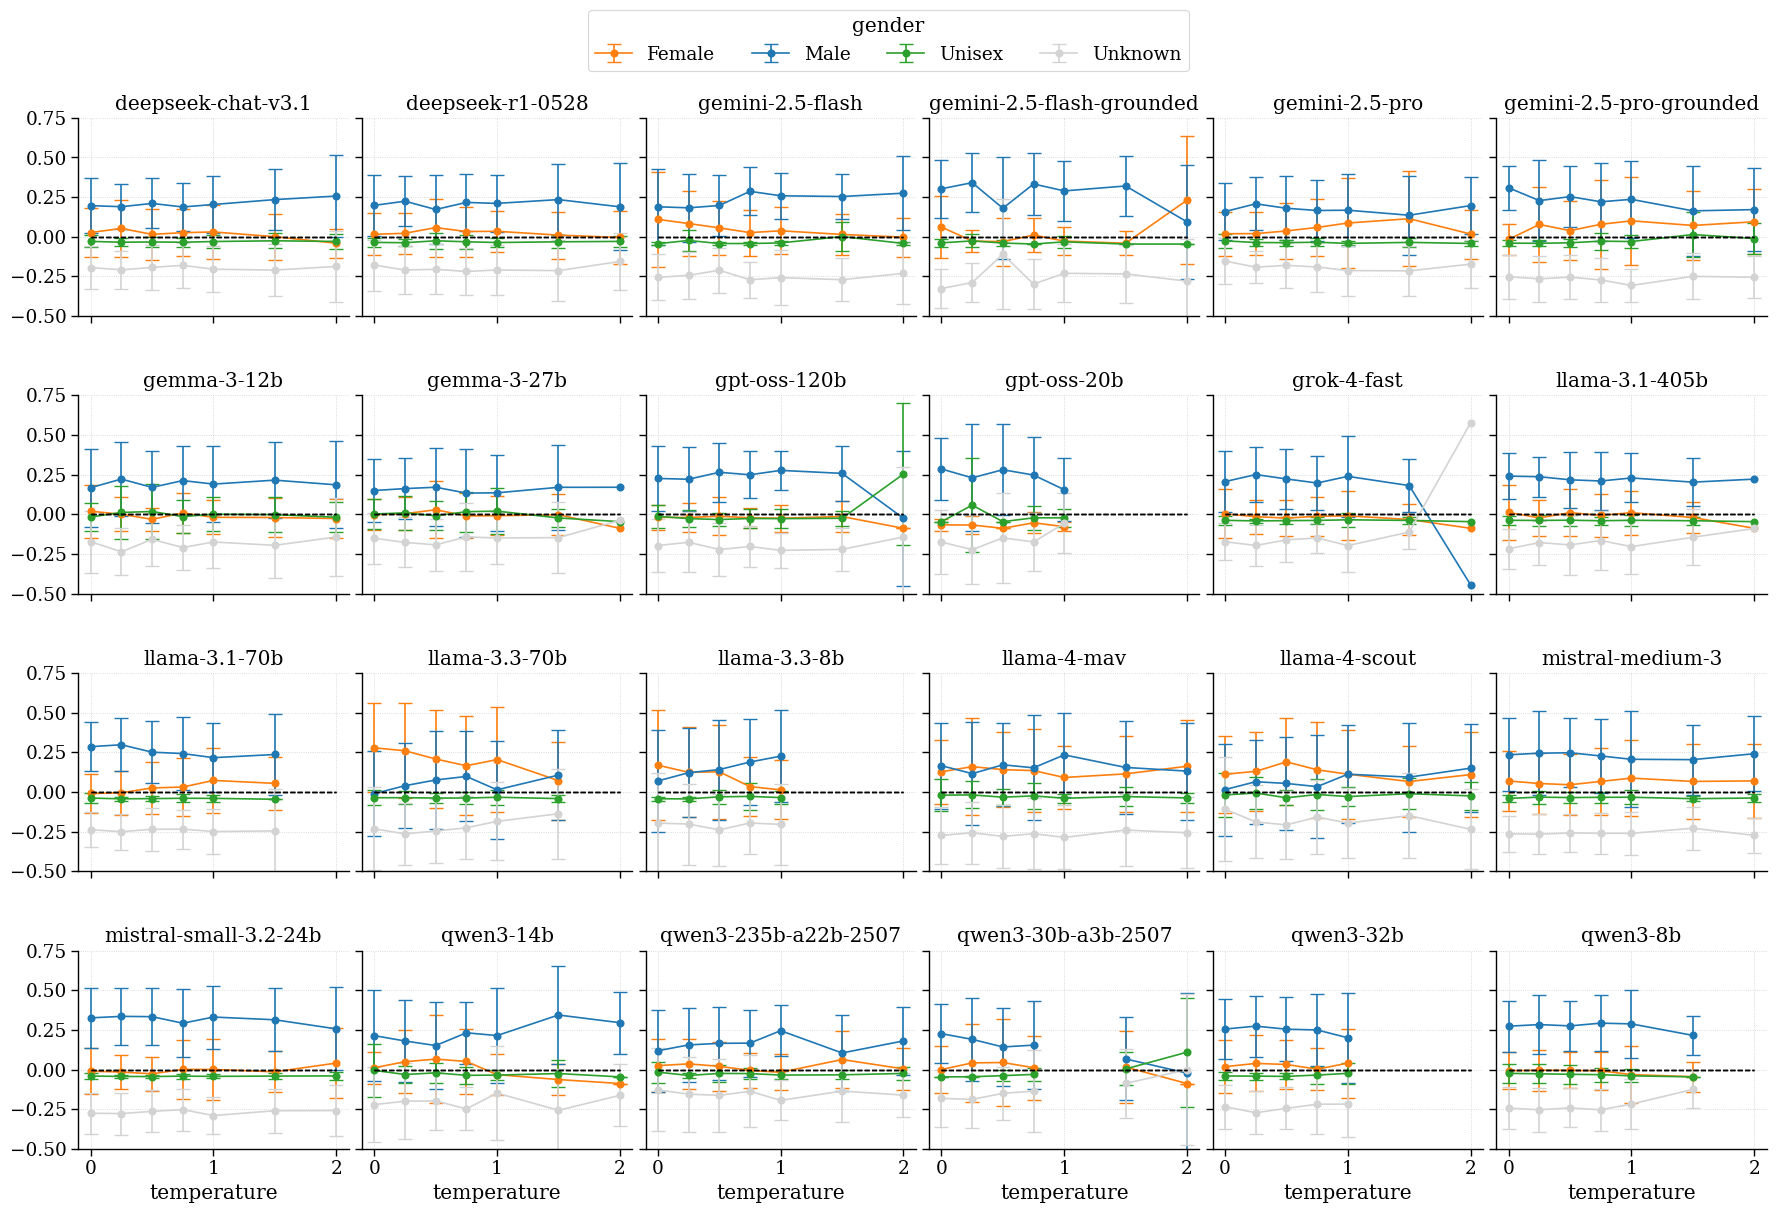

In [35]:
nmodels = df_model_gender['model'].nunique()
ncols = 6
nrows = int(vis.np.ceil(nmodels / ncols))
width = 3. * ncols
height = 3. * nrows

g_baselines = df_all_authors_demographics.groupby(cat_col).size() / df_all_authors_demographics.shape[0]

fig, axes = vis.plt.subplots(nrows, ncols, figsize=(width, height), sharex=True, sharey=True)
groups = []

for gender, df_gender in df_model_gender.groupby(cat_col, observed=False):

    gcolor = constants.GENDER_COLOR_DICT[gender]
    groups.append(gender)

    for idx, model in enumerate(df_gender['model'].unique()):
        
        col = idx % ncols
        row = idx // ncols
        ax = axes[row, col]

        df_subplot = df_gender.query("model == @model").copy()

        ax.set_title(model)
        #ax.errorbar(df_subplot['temperature'], df_subplot['mean'], yerr=df_subplot['std'], fmt='o-', capsize=5, label=gender, color=gcolor)
        #ax.hlines(g_baselines[gender], xmin=df_subplot['temperature'].min(), xmax=df_subplot['temperature'].max(), color=gcolor, linestyle='--', linewidth=1.5, alpha=0.7)

        ax.errorbar(df_subplot['temperature'],  df_subplot['mean'] - g_baselines[gender], yerr=df_subplot['std'], fmt='o-', capsize=5, label=gender, color=gcolor)
        ax.hlines(0, xmin=df_subplot['temperature'].min(), xmax=df_subplot['temperature'].max(), color='black', linestyle='--', linewidth=1., alpha=0.7, zorder=10e100)

        ax.set_ylim(-0.5, 0.75)
        ax.grid(linestyle=':', linewidth=0.6, alpha=0.6)

    # cosmetics
    for ax in axes[-1,:]:
        ax.set_xlabel("temperature")
        ax.grid(axis='y', linestyle=':', linewidth=0.6, alpha=0.6)

# put a single legend at the top
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, title=cat_col, ncol=len(groups), loc='upper center', bbox_to_anchor=(0.5, 1.02))

# final
vis.plt.tight_layout(rect=[0,0,1,0.96])
vis.plt.subplots_adjust(hspace=0.4, wspace=0.05)
vis.plt.show()
vis.plt.close()


## Ethnicity

In [36]:
cat_col = 'ethnicity'
df_model_ethnicity, df_task_ethnicity = bias.get_mean_percentages(df_authors, cat_col, {cat_col:constants.ETHNICITY_LIST})
df_model_ethnicity.head(2)

,temperature,model,ethnicity,mean,std
0,0.0,deepseek-chat-v3.1,Black or African American,0.077774,0.080213
1,0.0,deepseek-chat-v3.1,Hispanic or Latino,0.111069,0.121447


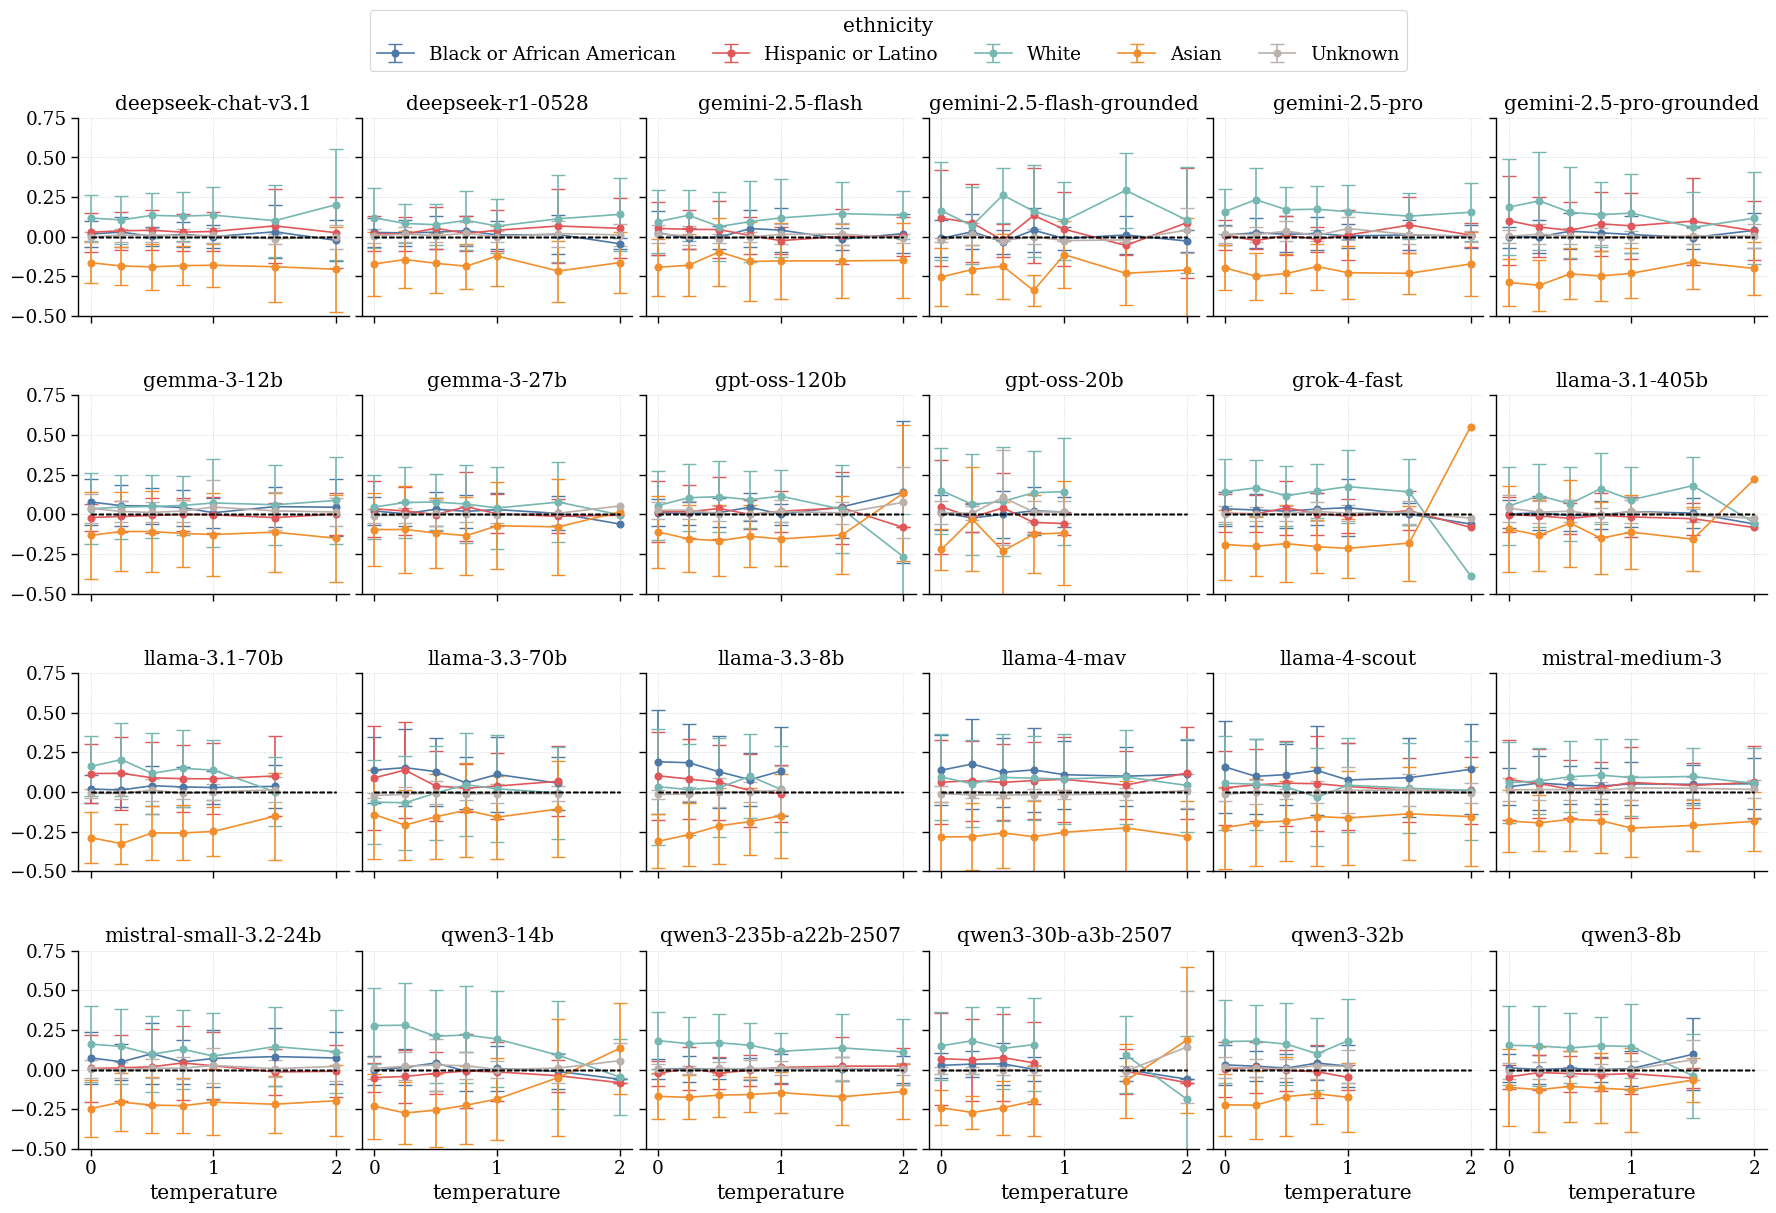

In [37]:
nmodels = df_model_ethnicity['model'].nunique()
ncols = 6
nrows = int(vis.np.ceil(nmodels / ncols))
width = 3. * ncols
height = 3. * nrows

g_baselines = df_all_authors_demographics.groupby(cat_col).size() / df_all_authors_demographics.shape[0]

fig, axes = vis.plt.subplots(nrows, ncols, figsize=(width, height), sharex=True, sharey=True)
groups = []

for ethnicity, df_ethnicity in df_model_ethnicity.groupby(cat_col, observed=False):

    gcolor = constants.ETHNICITY_COLOR_DICT[ethnicity]
    groups.append(ethnicity)

    for idx, model in enumerate(df_ethnicity['model'].unique()):
        
        col = idx % ncols
        row = idx // ncols
        ax = axes[row, col]

        df_subplot = df_ethnicity.query("model == @model").copy()

        ax.set_title(model)
        #ax.errorbar(df_subplot['temperature'], df_subplot['mean'], yerr=df_subplot['std'], fmt='o-', capsize=5, label=ethnicity, color=gcolor)
        #ax.hlines(g_baselines[ethnicity], xmin=df_subplot['temperature'].min(), xmax=df_subplot['temperature'].max(), color=gcolor, linestyle='--', linewidth=1.5, alpha=0.7)

        ax.errorbar(df_subplot['temperature'],  df_subplot['mean'] - g_baselines[ethnicity], yerr=df_subplot['std'], fmt='o-', capsize=5, label=ethnicity, color=gcolor)
        ax.hlines(0, xmin=df_subplot['temperature'].min(), xmax=df_subplot['temperature'].max(), color='black', linestyle='--', linewidth=1., alpha=0.7, zorder=10e100)

        ax.set_ylim(-0.5, 0.75)

        ax.grid(linestyle=':', linewidth=0.6, alpha=0.6)

    # cosmetics
    for ax in axes[-1,:]:
        ax.set_xlabel("temperature")
        ax.grid(axis='y', linestyle=':', linewidth=0.6, alpha=0.6)

# put a single legend at the top
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, title=cat_col, ncol=len(groups), loc='upper center', bbox_to_anchor=(0.5, 1.02))

# final
vis.plt.tight_layout(rect=[0,0,1,0.96])
vis.plt.subplots_adjust(hspace=0.4, wspace=0.05)
vis.plt.show()
vis.plt.close()


## Popularity

In [38]:
#@TODO

# Best temperature

In [39]:
# Based in factuality
df_best_temperature = df_best_temperature_by_factuality.copy()

gender_baselines = df_all_authors_demographics.groupby('gender').size() / df_all_authors_demographics.shape[0]
ethnic_baselines = df_all_authors_demographics.groupby('ethnicity').size() / df_all_authors_demographics.shape[0]

for id, row in df_best_temperature.iterrows():

    # consistency
    tmp = df_validity_normalized.query("model == @row['model'] and temperature == @row['temperature'] and result_valid_flag in @constants.EXPERIMENT_OUTPUT_VALID_FLAGS")
    df_best_temperature.loc[id, 'f_valid_responses'] = tmp.normalized_counts.sum()

    # gender bias
    for gender in constants.GENDER_LIST:
        g = gender.lower()
        g = 'neutral' if g == 'unisex' else g

        tmp = df_model_gender.query("model == @row['model'] and temperature == @row['temperature'] and gender == @gender")
        df_best_temperature.loc[id, f'f_{g}_llm'] = tmp.iloc[0]['mean']
        df_best_temperature.loc[id, f'f_{g}_gt'] = gender_baselines[gender]
        df_best_temperature.loc[id, f'f_{g}_bias'] = tmp.iloc[0]['mean'] - gender_baselines[gender]

    # ethinicity bias
    for ethnicity in constants.ETHNICITY_LIST:
        tmp = df_model_ethnicity.query("model == @row['model'] and temperature == @row['temperature'] and ethnicity == @ethnicity")
        df_best_temperature.loc[id, f'f_{ethnicity}_llm'] = tmp.iloc[0]['mean']
        df_best_temperature.loc[id, f'f_{ethnicity}_gt'] = ethnic_baselines[ethnicity]
        df_best_temperature.loc[id, f'f_{ethnicity}_bias'] = tmp.iloc[0]['mean'] - ethnic_baselines[ethnicity]
    
df_best_temperature

,model,temperature,mean,std,score,f_valid_responses,f_female_llm,f_female_gt,f_female_bias,f_male_llm,...,f_Hispanic or Latino_bias,f_White_llm,f_White_gt,f_White_bias,f_Asian_llm,f_Asian_gt,f_Asian_bias,f_Unknown_llm,f_Unknown_gt,f_Unknown_bias
0,deepseek-chat-v3.1,0.00,0.936312,0.056383,1.660635e+01,0.685185,0.114756,0.087721,0.027035,0.640612,...,0.028597,0.505962,0.387319,0.118643,0.282600,0.445918,-0.163318,0.022594,0.023731,-0.001137
1,deepseek-r1-0528,0.25,0.929553,0.060153,1.545318e+01,0.777778,0.109856,0.087721,0.022135,0.668617,...,0.017491,0.471323,0.387319,0.084005,0.302732,0.445918,-0.143186,0.040759,0.023731,0.017028
2,gemini-2.5-flash,0.50,0.935260,0.044983,2.079153e+01,0.722222,0.143897,0.087721,0.056176,0.641691,...,0.045619,0.451675,0.387319,0.064357,0.351178,0.445918,-0.094740,0.011659,0.023731,-0.012072
3,gemini-2.5-flash-grounded,0.50,0.975000,0.000000,9.750000e+99,0.388889,0.057143,0.087721,-0.030578,0.624351,...,-0.022154,0.650144,0.387319,0.262825,0.260967,0.445918,-0.184951,0.000000,0.023731,-0.023731
4,gemini-2.5-pro,0.75,0.937524,0.035024,2.676798e+01,0.666667,0.146711,0.087721,0.058989,0.610125,...,-0.015994,0.561228,0.387319,0.173909,0.258457,0.445918,-0.187462,0.032504,0.023731,0.008773
5,gemini-2.5-pro-grounded,1.00,0.914280,0.068320,1.338238e+01,0.777778,0.188334,0.087721,0.100613,0.680398,...,0.068932,0.536477,0.387319,0.149158,0.215734,0.445918,-0.230184,0.021565,0.023731,-0.002166
6,gemma-3-12b,0.25,0.733723,0.152305,4.817456e+00,1.000000,0.088782,0.087721,0.001060,0.666855,...,-0.012769,0.433979,0.387319,0.046660,0.338156,0.445918,-0.107762,0.042402,0.023731,0.018671
7,gemma-3-27b,0.25,0.885910,0.093503,9.474683e+00,1.000000,0.092007,0.087721,0.004286,0.606950,...,0.021443,0.462450,0.387319,0.075131,0.350940,0.445918,-0.094978,0.018464,0.023731,-0.005267
8,gpt-oss-120b,0.00,0.922499,0.071459,1.290956e+01,0.592593,0.069472,0.087721,-0.018250,0.670895,...,0.018058,0.442698,0.387319,0.055379,0.335801,0.445918,-0.110117,0.050283,0.023731,0.026552
9,gpt-oss-20b,0.00,0.966688,0.050585,1.911033e+01,0.203704,0.021639,0.087721,-0.066082,0.730486,...,0.047524,0.537504,0.387319,0.150185,0.224840,0.445918,-0.221078,0.035041,0.023731,0.011310


In [40]:
fn = io.path_join(RESULTS_PATH, 'best_temperatures_by_factuality.csv')
io.save_csv(df_best_temperature, fn)

[2025-12-16 02:10:30] Data successfully saved to ../results/temperature-analysis/best_temperatures_by_factuality.csv


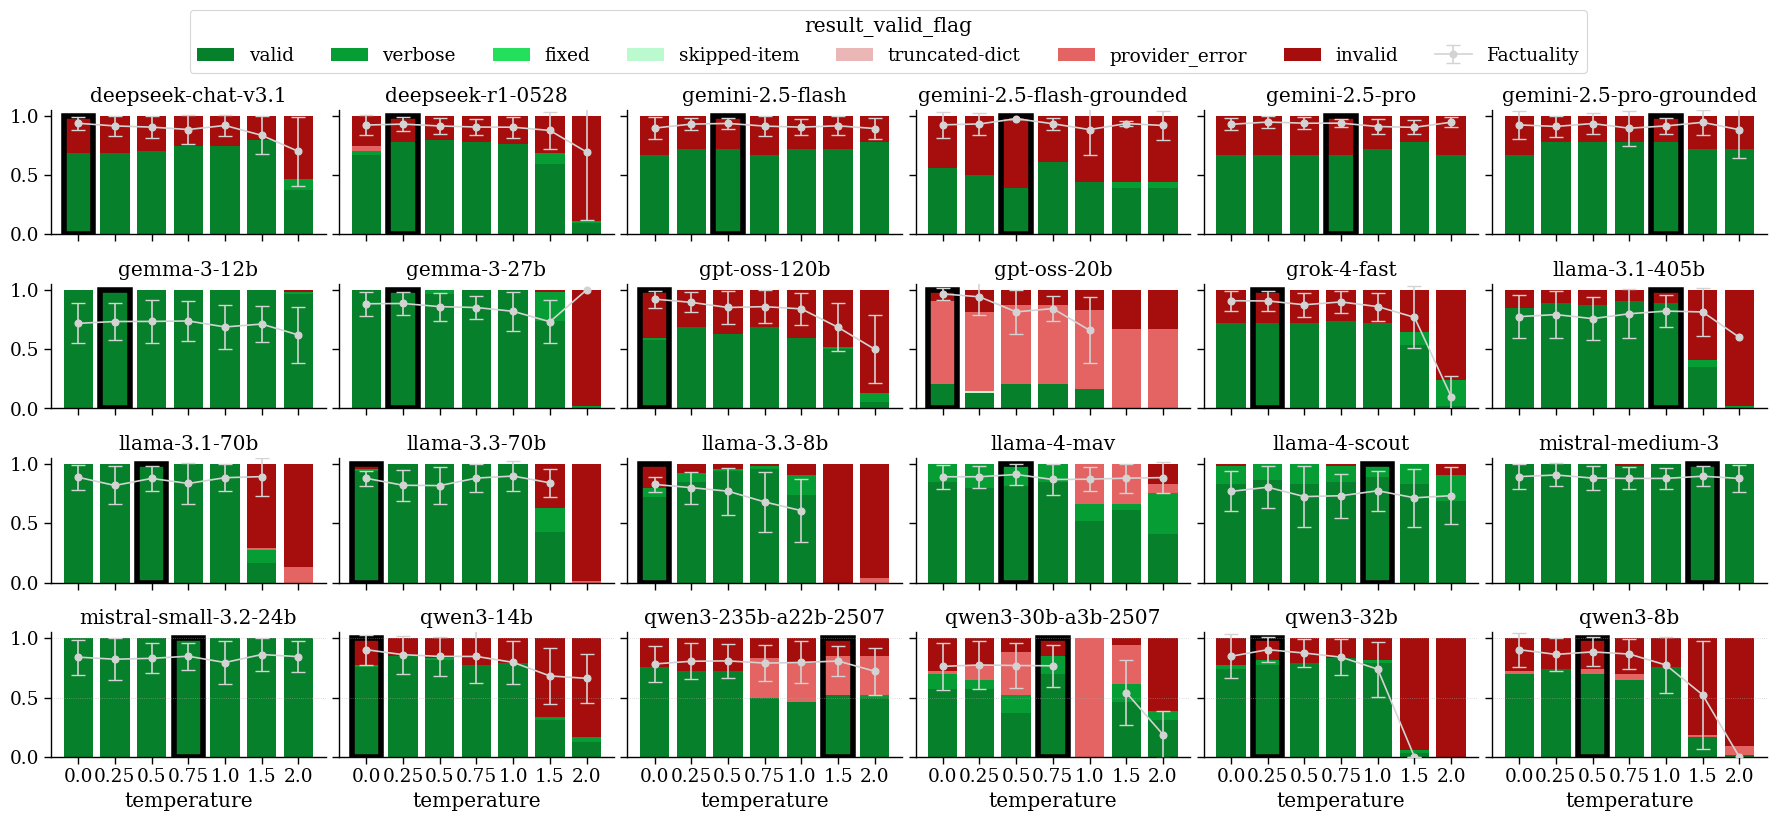

In [75]:
fn = io.path_join(PLOTS_PATH, 'best_temperature_factuality_consistency.pdf')
vis.plot_temperature_consistency(df_validity_normalized, 
                                 fn = fn, 
                                 df_best_temperature = df_best_temperature,
                                 df_factuality = df_fact_authors_either
                                 )

# Debugging

In [107]:
df_all_authors_stats = io.read_file_from_tar_gz_as_dataframe(APS_OA_DATA_TAR_GZ, constants.APS_OA_AUTHORS_STATS_FN)
df_all_authors_stats.rename(columns={'id_author':'id_author_oa'}, inplace=True)
df_all_authors_stats.shape

(481012, 30)

In [109]:
model = 'qwen3-14b'
temperature = 0.0
task_name = 'twins'
query = f"model=='{model}' and temperature=={temperature} and task_name=='{task_name}'"

In [132]:
all_fact_names = df_authors.query(query)[['model','temperature','date','time', 'task_name', 'task_param','clean_name', 'id_author_oa', 'fact_author_score']]
all_fact_names

,model,temperature,date,time,task_name,task_param,clean_name,id_author_oa,fact_author_score
210083,qwen3-14b,0.0,2025-10-09,14:00,twins,famous_female,albert laszlo barabasi,5.038977e+09,6.0
210084,qwen3-14b,0.0,2025-10-09,14:00,twins,famous_female,duncan j watts,5.018696e+09,7.0
210085,qwen3-14b,0.0,2025-10-09,14:00,twins,famous_female,steven h strogatz,5.029419e+09,7.0
210086,qwen3-14b,0.0,2025-10-09,14:00,twins,famous_female,alessandro vespignani,5.046547e+09,7.0
210087,qwen3-14b,0.0,2025-10-09,14:00,twins,famous_female,jennifer chayes,5.038662e+09,6.0
...,...,...,...,...,...,...,...,...,...
220768,qwen3-14b,0.0,2025-11-05,04:00,twins,random_male,david s goodsell,NaN,NaN
220769,qwen3-14b,0.0,2025-11-05,04:00,twins,random_male,robert m hochstrasser,5.026552e+09,7.0
220770,qwen3-14b,0.0,2025-11-05,04:00,twins,random_male,john h white,5.048701e+09,6.0
220771,qwen3-14b,0.0,2025-11-05,04:00,twins,random_male,michael a moore,5.072855e+09,6.0


In [131]:
all_names = io.read_csv(f"../results/temperature-analysis/valid_responses/{model}.csv", 
                        index_col=0).query(query)[['model','temperature','date','time', 'task_name', 'task_param','clean_name', 'valid_attempt', 'result_valid_flag']]
all_names

,model,temperature,date,time,task_name,task_param,clean_name,valid_attempt,result_valid_flag
850,qwen3-14b,0.0,2025-10-09,14:00,twins,famous_female,albert laszlo barabasi,True,valid
851,qwen3-14b,0.0,2025-10-09,14:00,twins,famous_female,duncan j watts,True,valid
852,qwen3-14b,0.0,2025-10-09,14:00,twins,famous_female,steven h strogatz,True,valid
853,qwen3-14b,0.0,2025-10-09,14:00,twins,famous_female,alessandro vespignani,True,valid
854,qwen3-14b,0.0,2025-10-09,14:00,twins,famous_female,jennifer chayes,True,valid
...,...,...,...,...,...,...,...,...,...
16417,qwen3-14b,0.0,2025-11-05,04:00,twins,random_male,david s goodsell,True,valid
16418,qwen3-14b,0.0,2025-11-05,04:00,twins,random_male,robert m hochstrasser,True,valid
16419,qwen3-14b,0.0,2025-11-05,04:00,twins,random_male,john h white,True,valid
16420,qwen3-14b,0.0,2025-11-05,04:00,twins,random_male,michael a moore,True,valid


In [130]:
df_fact_authors_either.query("model == @model and temperature == @temperature and task_name == @task_name")

,model,temperature,task_name,mean,std
669,qwen3-14b,0.0,twins,0.675439,0.374799


In [ ]:
gn = ['date', 'time', 'task_name', 'task_param']
for g, v in all_names.groupby(gn, observed=True).size().items():
    tmp = all_fact_names.query(f"date=='{g[0]}' and time=='{g[1]}' and task_name=='{g[2]}' and task_param=='{g[3]}'")
    print(g, v, tmp.shape[0], v/tmp.shape[0], tmp.fact_author_score.mean(), tmp.fact_author_score.tolist())


('2025-10-09', '14:00', 'twins', 'famous_female') 6 6 1.0 6.666666666666667 [6.0, 7.0, 7.0, 7.0, 6.0, 7.0]
('2025-10-09', '14:00', 'twins', 'famous_male') 5 5 1.0 6.8 [7.0, 7.0, 7.0, 7.0, 6.0]
('2025-10-09', '14:00', 'twins', 'fictitious_female') 1 1 1.0 nan [nan]
('2025-10-09', '14:00', 'twins', 'movie_male') 5 5 1.0 7.5 [6.0, 8.0, 9.0, nan, 7.0]
('2025-10-09', '14:00', 'twins', 'random_female') 3 3 1.0 6.0 [nan, nan, 6.0]
('2025-10-09', '14:00', 'twins', 'random_male') 4 4 1.0 7.0 [7.0, 6.0, 8.0, 7.0]
('2025-11-04', '18:00', 'twins', 'famous_female') 6 6 1.0 6.666666666666667 [6.0, 7.0, 7.0, 7.0, 6.0, 7.0]
('2025-11-04', '18:00', 'twins', 'famous_male') 4 4 1.0 7.0 [7.0, 7.0, 7.0, 7.0]
('2025-11-04', '18:00', 'twins', 'fictitious_female') 1 1 1.0 nan [nan]
('2025-11-04', '18:00', 'twins', 'fictitious_male') 2 2 1.0 7.0 [nan, 7.0]
('2025-11-04', '18:00', 'twins', 'movie_male') 5 5 1.0 7.6 [6.0, 8.0, 9.0, 7.0, 8.0]
('2025-11-04', '18:00', 'twins', 'random_female') 3 3 1.0 6.5 [7.0, nan

In [140]:
import numpy as np
np.mean([6/6,5/5,0,4/5,1/3.,4/4,6/6,4/4,0,1/2,5/5,2/3,1/3,6/6,6/6,0,4/5,3/5,4/5])

np.float64(0.6754385964912281)